In [33]:
# import tqdm.notebook as tq
from tqdm.notebook import tqdm
import csv
import os
import pandas as pd
from skimage import io

from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Subset

import matplotlib.pyplot as plt

## Choose dataset. 
- `data_path = "irm/landbird"` for 2 classes, both landbirds sampled from mixed environments
- `data_path = "irm/data"` for 2 classes, one land bird/one water bird, mixed environments 
- `data_path = "irm/waterbirds"` for *all* classes, mixed environments 

In [2]:
# data_path = "irm/data/"
data_path = "data/"

print("Device name:",torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#  !ls -la "/content/data/"

Device name: NVIDIA GeForce RTX 3060


In [14]:
H, W = 300, 500
transform = transforms.Compose([
    transforms.Resize((H,W)),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

imgs = torchvision.datasets.ImageFolder(data_path, transform)

In [4]:
# get waterbirds; returns dict birds
# 1,001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg,1,2,1,/o/ocean/00002178.jpg
# img_id,img_filename,y,split,place,place_filename
def get_place():
    '''
    Gets a dictionary mapping file names to environment ID

    Returns:    
        dict with values (string) filename mapped to
        keys (int) for environment ID*

        *1 corresponds to water environment (ocean) and
        *0 corresponds to land environment

    Example entry:
        # print(get_place())
        # '001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg': 1, 
        # '001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg': 1,	
    '''
    birds = {}
    with open( data_path+'metadata.csv') as f:
        reader = csv.DictReader(f)
        for row in reader:
            fname = row['img_filename'].split('/')[-1]
            birds[fname] = int(row['place'])
    return birds

def split_dataset(meta_fname=data_path+"metadata.csv"):
    '''
    Appendix C.1 of DRO paper:
    50-20-30 train-val-test split that allocates 
    more examples to the validation and test sets than the standard 
    split.
    '''
    train_land = []
    train_water = []
    val_land = []
    val_water = []
    test_land = []
    test_water = []
    train = []
    with open(meta_fname) as f:
        reader = csv.DictReader(f)
        for row in reader:    
            match int(row['split']), int(row['place']):
                case 0,0:
                    train_land.append(int(row['img_id']))
                    train.append(int(row['img_id']))
                case 0,1:
                    train_water.append(int(row['img_id']))
                    train.append(int(row['img_id']))
                case 1,0:
                    val_land.append(int(row['img_id']))
                case 1,1:
                    val_water.append(int(row['img_id']))
                case 2,0:
                    test_land.append(int(row['img_id']))
                case 2,1:
                    test_water.append(int(row['img_id']))
    return train_land, train_water, val_land, val_water, test_land, test_water, train

def train_val_dataset(imgs):
    train_land, train_water, val_land, val_water, test_land, test_water,\
        train \
        = split_dataset()
    datasets = {}
    datasets['train'] =  Subset(imgs, train)
    datasets['train_land'] = Subset(imgs, train_land)
    datasets['train_water'] = Subset(imgs, train_water)
    datasets['val_land'] = Subset(imgs, val_land)
    datasets['val_water'] = Subset(imgs, val_water)
    datasets['test_land'] = Subset(imgs, test_land )
    datasets['test_land'] = Subset(imgs, test_water)
    datasets['val'] =  Subset(imgs, val_land + val_water)
    datasets['test'] = Subset(imgs, test_land + test_water)
    return datasets

train_val_dataset(imgs)

{'train': <torch.utils.data.dataset.Subset at 0x197a58064d0>,
 'train_land': <torch.utils.data.dataset.Subset at 0x197a5807c70>,
 'train_water': <torch.utils.data.dataset.Subset at 0x197c3f63d60>,
 'val_land': <torch.utils.data.dataset.Subset at 0x197c3fac1c0>,
 'val_water': <torch.utils.data.dataset.Subset at 0x197c3fad720>,
 'test_land': <torch.utils.data.dataset.Subset at 0x197c3fae650>,
 'val': <torch.utils.data.dataset.Subset at 0x197c3fae6b0>,
 'test': <torch.utils.data.dataset.Subset at 0x197c3faca90>}

In [91]:
class EnvDataset(Dataset):
    """ waterbirds + environment dataset"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.metadata = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.metadata.iloc[idx][1]))
        image = io.imread(img_name)
        print(self.metadata.iloc[idx])
        env = self.metadata.iloc[idx]['place']
        sample = {'image': image, 'env': env}

        # if self.transform:
        #     sample = self.transform(sample)

        return sample

In [92]:
ds = EnvDataset(csv_file='data/metadata.csv', root_dir='data/')
birds = get_place()
dataloader = DataLoader(ds, batch_size=4,
                        shuffle=True, num_workers=0)

In [93]:
datasets = train_val_dataset(imgs)
BATCH_SIZE = 8

train_loader = DataLoader(
    datasets['train'].dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    # careful when dealing with mixed env points
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

val_loader = DataLoader(
    datasets['val'].dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    # careful when dealing with mixed env points
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

In [94]:
class BasicConvNet(nn.Module):
    '''
    A basic neural network. Not particularly based on anything,
    2 conv layers and last layer is FC.
    '''

    def __init__(self, num_classes, num_envs=2):
        super(BasicConvNet, self).__init__()
        self.conv2d1 = nn.Conv2d(3, 2, 3, 1, 1)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2d2 = nn.Conv2d(2, 4, 3, 1, 1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()

        # For this part, we want one dense layer for the frist
        # and one dense layer for the second environment
        self.fc1 = nn.Linear(12544, num_classes)
        self.fc2 = nn.Linear(12544, num_classes)
        self._weight_init()

    def _weight_init(self):
        for layer in self.children():
            if (layer.__class__.__name__ == 'Linear' \
                or layer.__class__.__name__ == 'Conv2d'):
                nn.init.kaiming_uniform_(layer.weight.data,0.2)
                nn.init.constant_(layer.bias.data,0)  

    def forward(self, x, env):
        '''
        env: integer parameter. 0 for land, 1 for water
        '''
        x = self.conv2d1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2d2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.relu(x)
        x = self.flatten(x)

        if env == 0:
            x = self.fc1(x)
        else:
            x = self.fc2(x)
            
        return x

## Baseline
A regular small neural network. ERM only, ignore environments.

`todo`: IRM baseline

  0%|          | 0/50 [00:00<?, ?it/s]

E: 0; Loss: 0.7136045694351196;
E: 10; Loss: 0.2979872226715088;
E: 20; Loss: 0.037518031895160675;
E: 30; Loss: 0.02281118929386139;
E: 40; Loss: 0.02362651377916336;
Average Validation Loss: 0.005351968575268984;


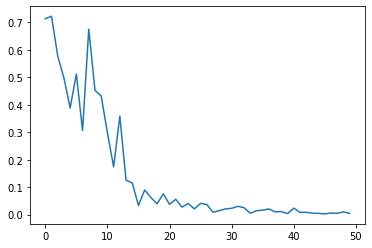

In [95]:
lr = 0.01
n_epochs = 50
birds = get_place()
baseline = BasicConvNet(num_classes=2)
optimizer = optim.SGD(baseline.parameters(), lr=lr)
optimizer.zero_grad()
criterion = nn.CrossEntropyLoss()

def train_baseline(data_loader, net):
    losses = torch.Tensor(n_epochs,2)
    for epoch in tqdm(range(n_epochs)):
        for batch_idx, data in enumerate(data_loader):
            inputs, labels = data

            # inputs are currently sorted
            sample_fname, _ = data_loader.dataset.samples[batch_idx]
            fname = sample_fname.split('/')[-1]
            # filename example: Black_Footed_Albatross_0009_34.jpg

            optimizer.zero_grad()
            outputs = net(inputs, 0) #just use fc1
            loss = criterion(outputs, labels.type(torch.LongTensor)) 
            loss.backward()
            optimizer.step()
            losses[epoch,0] = loss.item()

        if epoch % 10 == 0:
            print(f"E: {epoch}; Loss: {loss.item()};" )
    return losses

def test(data_loader, model):
    losses=[]
    for batch_idx, data in enumerate(data_loader):
        inputs, labels = data
        sample_fname, _ = data_loader.dataset.samples[batch_idx]
        fname = sample_fname.split('/')[-1]
        outputs = model(inputs, 0) #just use fc1
        loss = criterion(outputs, labels.type(torch.LongTensor)) 
        losses.append(loss.item())
    
    avg_loss = torch.mean(torch.FloatTensor(losses))
    print(f"Average Validation Loss: {avg_loss};" )
    return avg_loss

train_losses = train_baseline(train_loader, baseline)
baseline_loss = test(val_loader, baseline)

plt.plot(train_losses[:,0], label="loss")
plt.show()

## Phase 1
Train featurizers and classifiers together for all environments.
Both featurizer and classifier should be mutable (are being trained).

Featurizer should be same for samples from all environments,
classifier should be different for samples from different environments.

In [96]:
# need 2 different loss functions. 
# such that they have gradient = 0 on half the weights
# for the irrelevant environment
SANITY_CHECK = False

def train_phase1(data_loader, net):
    losses = torch.Tensor(n_epochs,2)
    for epoch in tqdm(range(n_epochs)):
        for batch_idx, (inputs, labels) in enumerate(data_loader, 0):
            print(inputs.shape)
            break
            sample_fname, _ = train_loader.dataset.samples[batch_idx]
            fname = os.path.split(sample_fname)[-1]

            if birds[fname] == 0:
                # Train land-env birds
                optimizer.zero_grad()
                outputs = net(inputs, 0)
                land_loss = criterion(outputs, labels.type(torch.LongTensor)) 
                land_loss.backward()
                optimizer.step()
                losses[epoch,0] = land_loss.item()
                
            elif birds[fname] == 1:
                if SANITY_CHECK:
                # skip; these are water backgrounds. Train only on land bg
                # see if corresponding dense layer (fc2) is connected
                    water_loss=0
                else:
                # Train water-env birds
                    optimizer.zero_grad()
                    outputs = net(inputs, 1)
                    water_loss = criterion(outputs, labels.type(torch.LongTensor)) 
                    water_loss.backward()
                    optimizer.step()
                    losses[epoch,1] = water_loss.item()
        if epoch % 10 == 9:
            if SANITY_CHECK:
                print(f"E: {epoch}; Land Loss: {land_loss.item()};" )
            else:
                print(f"E: {epoch}; Land Loss: {land_loss.item()}; \
                Water Loss: {water_loss.item()}")
    return losses

In [97]:
# Training phase 1
lr = 0.01
n_epochs = 50
birds = get_place()
net = BasicConvNet(num_classes=2)

optimizer = optim.SGD(net.parameters(), lr=lr)
optimizer.zero_grad()
criterion = nn.CrossEntropyLoss()

train_losses = train_phase1(dataloader, net)

  0%|          | 0/50 [00:00<?, ?it/s]

img_id                                                        11126
img_filename      189.Red_bellied_Woodpecker/Red_Bellied_Woodpec...
y                                                                 0
split                                                             2
place                                                             1
place_filename                                /o/ocean/00003005.jpg
Name: 114, dtype: object
img_id                                                           17
img_filename      001.Black_footed_Albatross/Black_Footed_Albatr...
y                                                                 1
split                                                             2
place                                                             1
place_filename                                /o/ocean/00004537.jpg
Name: 16, dtype: object
img_id                                                        11108
img_filename      189.Red_bellied_Woodpecker/Red_Bellied_Woodpec...

RuntimeError: stack expects each tensor to be equal size, but got [333, 500, 3] at entry 0 and [350, 350, 3] at entry 1

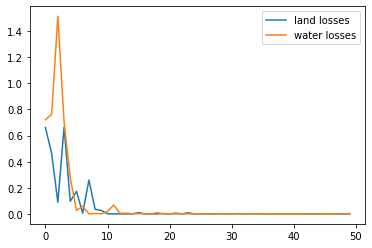

In [ ]:
plt.plot(train_losses[:,0], label="land losses")
plt.plot(train_losses[:,1], label="water losses")
plt.legend()
plt.show()

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())
torch.save(net.state_dict(), "phase1")

Model's state_dict:
conv2d1.weight 	 torch.Size([2, 3, 3, 3])
conv2d1.bias 	 torch.Size([2])
conv2d2.weight 	 torch.Size([4, 2, 3, 3])
conv2d2.bias 	 torch.Size([4])
fc1.weight 	 torch.Size([2, 12544])
fc1.bias 	 torch.Size([2])
fc2.weight 	 torch.Size([2, 12544])
fc2.bias 	 torch.Size([2])


## Phase 2

Train classifiers for environments only, freezing featurizers

In [ ]:
def freeze_featurizer(net):
    for layer in net.children():
        # unless it's the last linear layer, freeze everything.
        for p in layer.parameters():
            p.requires_grad = False
        if layer.__class__.__name__ == 'Linear':
            # if it's one of the first environment weights, let it train
            for i,p in enumerate(layer.parameters()):
                if i < 2: p.requires_grad=True

    for layer in net.children():
        print(layer.__class__.__name__)
        for p in layer.parameters(): 
            # TODO: fix this! It just does weight, bias as the two parameters.
            print("is frozen: ", str(not p.requires_grad))

In [ ]:
def train_phase2(data_loader,net):
    l_optim_frozen = optim.SGD(
        filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
    losses = torch.Tensor(n_epochs)

    for epoch in tq.tqdm(range(n_epochs)):
        for batch_idx, data in enumerate(data_loader):
            inputs, labels = data
            l_optim_frozen.zero_grad()

            sample_fname, _ = data_loader.dataset.samples[batch_idx]
            fname = sample_fname.split('/')[-1]

            # Train land-env birds
            outputs = net(inputs, 0) 
        
            # we're only working with the first weights now 
            loss = criterion(outputs, labels.type(torch.LongTensor)) 
            loss.backward()
            l_optim_frozen.step()
            losses[epoch] = loss.item()

        if epoch % 10 == 9:    
            print(f"E: {epoch}; Loss: {loss.item()}")

  0%|          | 0/50 [00:00<?, ?it/s]

E: 9; Loss: 3.218599158572033e-05
E: 19; Loss: 0.0
E: 29; Loss: 0.0004757702990900725
E: 39; Loss: 2.729855441430118e-05
E: 49; Loss: 3.2543604902457446e-05


In [ ]:
freeze_featurizer(net)
train_phase2(train_loader, net)
test(val_loader, net)

NameError: name 'freeze_featurizer' is not defined

torch.Size([50])
tensor([6.3894e-05, 1.9751e-04, 1.4674e-04, 4.7684e-06, 1.8166e-04, 5.5083e-04,
        6.5205e-05, 0.0000e+00, 3.3492e-04, 3.2186e-05, 5.0615e-04, 1.4161e-04,
        1.2516e-04, 2.2266e-04, 1.4781e-04, 5.2272e-04, 4.3034e-05, 1.4054e-04,
        1.3471e-05, 0.0000e+00, 1.7403e-04, 7.0212e-05, 4.3407e-04, 2.1458e-06,
        5.2452e-06, 1.7451e-04, 9.5548e-04, 3.0739e-04, 2.1336e-04, 4.7577e-04,
        1.1921e-07, 0.0000e+00, 7.8678e-06, 2.8371e-05, 2.1408e-04, 2.6941e-05,
        1.6080e-04, 4.8994e-05, 7.8695e-04, 2.7299e-05, 1.5497e-06, 4.0714e-04,
        2.1815e-05, 8.5231e-05, 4.6385e-04, 1.9942e-04, 3.2110e-04, 4.2418e-04,
        5.2452e-06, 3.2544e-05])


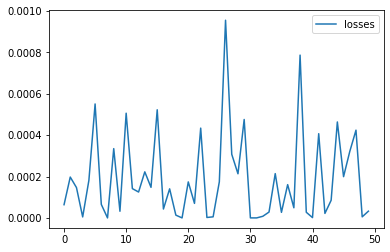

In [ ]:
print(losses.shape)
print(losses)
plt.plot(losses, label="losses")
plt.legend()
plt.show()